In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw




Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


(1, 28, 28)


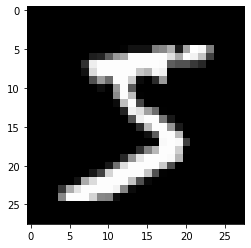

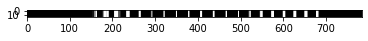

In [35]:
import matplotlib.pyplot as plt
import numpy as np

tmp_data = mnist_train[0][0].numpy()
print(tmp_data.shape)
plt.imshow(tmp_data.squeeze(),cmap='gray')
plt.show()

tmp_list = [ tmp_data.reshape(-1) for _ in range(15)]
plt.imshow(np.stack(tmp_list).squeeze(),cmap='gray')
plt.show()

In [7]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,    # Cuation - in test loader : shuffle = False
                                          drop_last=True) # Caution - in test loader  : drop_last = False

In [12]:
# MNIST data image of shape 28 * 28 = 784
linear = torch.nn.Linear(784, 10, bias=True).to(device)

In [13]:
linear.weight

Parameter containing:
tensor([[ 0.0185,  0.0145,  0.0128,  ..., -0.0113, -0.0234, -0.0064],
        [ 0.0156,  0.0160, -0.0068,  ...,  0.0211,  0.0332,  0.0243],
        [-0.0314,  0.0059, -0.0335,  ..., -0.0068,  0.0051, -0.0076],
        ...,
        [ 0.0140,  0.0202,  0.0016,  ..., -0.0123,  0.0006,  0.0054],
        [-0.0352, -0.0268, -0.0214,  ...,  0.0080, -0.0307,  0.0200],
        [ 0.0337,  0.0302,  0.0209,  ...,  0.0008,  0.0168,  0.0084]],
       device='cuda:0', requires_grad=True)

In [14]:
# Initialization - it is arbitrary
torch.nn.init.normal_(linear.weight)

Parameter containing:
tensor([[-1.3431e+00, -1.1908e+00, -1.7706e+00,  ..., -5.8582e-01,
         -9.7819e-01,  1.0302e+00],
        [ 8.9247e-02, -1.2811e-01, -4.3244e-01,  ..., -6.6606e-01,
          1.2240e+00, -8.8232e-03],
        [-7.5193e-01,  1.8395e+00, -1.0421e-01,  ..., -1.5682e-03,
         -8.7444e-01, -2.8767e+00],
        ...,
        [-2.2187e+00, -1.3841e+00,  1.5232e-01,  ..., -3.6639e-01,
         -5.8011e-01, -5.4267e-01],
        [ 1.5435e+00,  1.5100e+00, -7.8249e-01,  ..., -3.3028e-02,
         -2.2677e+00, -3.3882e-02],
        [ 1.5835e+00, -1.3306e+00, -6.6267e-01,  ...,  8.5629e-02,
          8.0697e-02, -8.9305e-01]], device='cuda:0', requires_grad=True)

In [25]:
for param in linear.parameters():
    print(param)

Parameter containing:
tensor([[-1.3431e+00, -1.1908e+00, -1.7706e+00,  ..., -5.8582e-01,
         -9.7819e-01,  1.0302e+00],
        [ 8.9247e-02, -1.2811e-01, -4.3244e-01,  ..., -6.6606e-01,
          1.2240e+00, -8.8232e-03],
        [-7.5193e-01,  1.8395e+00, -1.0421e-01,  ..., -1.5682e-03,
         -8.7444e-01, -2.8767e+00],
        ...,
        [-2.2187e+00, -1.3841e+00,  1.5232e-01,  ..., -3.6639e-01,
         -5.8011e-01, -5.4267e-01],
        [ 1.5435e+00,  1.5100e+00, -7.8249e-01,  ..., -3.3028e-02,
         -2.2677e+00, -3.3882e-02],
        [ 1.5835e+00, -1.3306e+00, -6.6267e-01,  ...,  8.5629e-02,
          8.0697e-02, -8.9305e-01]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0143, -0.0313,  0.0158,  0.0082, -0.0025, -0.0092,  0.0029,  0.0294,
         0.0154,  0.0308], device='cuda:0', requires_grad=True)


In [8]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(linear.parameters(), lr=learning_rate)

In [9]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 4.848181248
Epoch: 0002 cost = 1.464641452
Epoch: 0003 cost = 0.977406502
Epoch: 0004 cost = 0.790303528
Epoch: 0005 cost = 0.686833322
Epoch: 0006 cost = 0.618483305
Epoch: 0007 cost = 0.568978667
Epoch: 0008 cost = 0.531290889
Epoch: 0009 cost = 0.501056492
Epoch: 0010 cost = 0.476258427
Epoch: 0011 cost = 0.455025405
Epoch: 0012 cost = 0.437031567
Epoch: 0013 cost = 0.421489984
Epoch: 0014 cost = 0.408599794
Epoch: 0015 cost = 0.396514893
Learning finished


In [10]:
# Test the model using test sets
with torch.no_grad(): # important!
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.8944000005722046
Label:  8
Prediction:  8
